In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import sklearn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from scipy.special import softmax

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("always", ConvergenceWarning)

In [2]:
from maml.datasets.miniimagenet import MiniimagenetMetaDataset
from maml.models.gated_conv_net_original import ImpRegConvModel
from maml.models.conv_embedding_model import RegConvEmbeddingModel
from maml.logistic_regression_utils import logistic_regression_grad_with_respect_to_w, logistic_regression_hessian_pieces_with_respect_to_w, logistic_regression_hessian_with_respect_to_w, logistic_regression_mixed_derivatives_with_respect_to_w_then_to_X
from maml.logistic_regression_utils import logistic_regression_mixed_derivatives_with_respect_to_w_then_to_X_left_multiply

In [3]:
num_channels = 64
dataset = MiniimagenetMetaDataset(
    root='data',
    img_side_len=84,
    num_classes_per_batch=5,
    num_samples_per_class=5, # num train samples per class
    num_total_batches=10,
    num_val_samples=595, # num test samples per class
    meta_batch_size=10,
    split='train', # meta train/val/test
    num_workers=4,
    device='cuda')

MiniImagenet train


In [4]:
for train_task_batch, test_task_batch in iter(dataset):
    break

In [5]:
train_task = train_task_batch[0]
test_task = test_task_batch[0]
print(train_task.x.shape)

torch.Size([25, 3, 84, 84])


In [6]:
images = test_task.x.cpu().numpy().transpose(0,2,3,1)

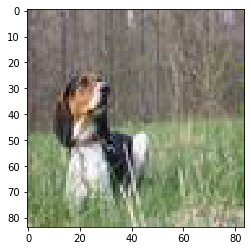

In [7]:
plt.imshow(images[0])

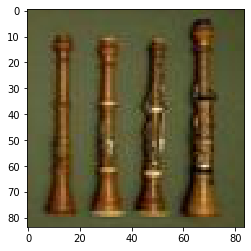

In [8]:
plt.imshow(images[595])

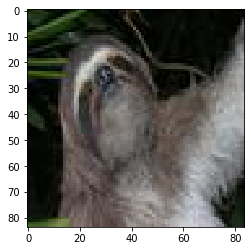

In [9]:
plt.imshow(images[1190])

In [10]:
model = ImpRegConvModel(
        input_channels=dataset.input_size[0],
        output_size=dataset.output_size,
        num_channels=num_channels,
        img_side_len=dataset.input_size[1],
        use_max_pool=False, # currently not used
        verbose=False)

In [11]:
state_dict = torch.load('./train_dir/impregmaml_mini_5w5s_no_modulation_l2_10/maml_impregconv_59000.pt')
model.load_state_dict(state_dict['model'])
model.to('cuda')

ImpRegConvModel(
  (features): Sequential(
    (layer1_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer1_relu): ReLU(inplace=True)
    (layer1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=False, track_running_stats=True)
    (layer1_max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer2_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer2_relu): ReLU(inplace=True)
    (layer2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=False, track_running_stats=True)
    (layer2_max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer3_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer3_relu): ReLU(inplace=True)
    (layer3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=False, track_running_stats=True)
    (layer3_max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [14]:
for a in model.features.named_children():
    print(a)

('layer1_conv', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('layer1_relu', ReLU(inplace=True))
('layer1_bn', BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=False, track_running_stats=True))
('layer1_max_pool', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
('layer2_conv', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('layer2_relu', ReLU(inplace=True))
('layer2_bn', BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=False, track_running_stats=True))
('layer2_max_pool', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
('layer3_conv', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('layer3_relu', ReLU(inplace=True))
('layer3_bn', BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=False, track_running_stats=True))
('layer3_max_pool', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
('layer4_conv', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

In [15]:
# model.eval()

ImpRegConvModel(
  (features): Sequential(
    (layer1_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer1_relu): ReLU(inplace=True)
    (layer1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=False, track_running_stats=True)
    (layer1_max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer2_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer2_relu): ReLU(inplace=True)
    (layer2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=False, track_running_stats=True)
    (layer2_max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer3_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer3_relu): ReLU(inplace=True)
    (layer3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=False, track_running_stats=True)
    (layer3_max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [12]:
X = model(train_task.x, modulation=None)

Before Modulation
tensor([ 59.9212,  64.0310,  92.7452,  83.2430,  75.0137,  59.4221,  75.5973,
         57.6635,  61.5437,  68.8086,  65.5655,  78.6150,  70.7616,  65.6413,
         81.4199,  75.6630,  83.9960,  71.5949, 103.3228,  61.6168,  69.3403,
         58.7152,  64.9129,  61.9011,  60.0422], device='cuda:0',
       grad_fn=<NormBackward1>)


In [23]:
# result = []
# with torch.no_grad():
#     for i in range(192):
#         result.append(model(train_task.x[i * 50: (i+1) * 50], modulation=None))

In [24]:
# print(train_task.x.shape)
# X = torch.cat(result, dim=0)
# print(X.shape)

torch.Size([9600, 3, 84, 84])
torch.Size([9600, 1601])


In [13]:
X = X.detach().cpu().numpy()
y = (train_task.y).cpu().numpy()

In [14]:
print(y)

[3 3 3 3 3 1 1 1 1 1 4 4 4 4 4 2 2 2 2 2 0 0 0 0 0]


In [15]:
l2_lambda = 10

In [16]:
with warnings.catch_warnings(record=True) as wn:
    lr_model = LogisticRegression(solver='lbfgs', penalty='l2', 
        C=1/l2_lambda, # now use _l2_lambda instead of 2 * _l2_lambda
        tol=1e-6, max_iter=1000,
        multi_class='multinomial', fit_intercept=False)
    lr_model.fit(X, y)

In [17]:
np.sum(lr_model.predict(X) == y)

25

In [18]:
indices = []
for i in range(5):
    for j in range(5):
        indices.append(595 * i + j)
print(indices)

[0, 1, 2, 3, 4, 595, 596, 597, 598, 599, 1190, 1191, 1192, 1193, 1194, 1785, 1786, 1787, 1788, 1789, 2380, 2381, 2382, 2383, 2384]


In [20]:
X_test = model(test_task.x[indices], modulation=None)
X_test = X_test.detach().cpu().numpy()
y_test = (test_task.y[indices]).cpu().numpy()

In [ ]:
# test_result = []
# test_result.append(model(test_task.x[0:5], modulation=None))
# test_result.append(model(test_task.x[595:600], modulation=None))

In [24]:
# X_test = model(test_task.x, modulation=None)
# X_test = X_test.detach().cpu().numpy()
# y_test = (test_task.y).cpu().numpy()

In [24]:
print(test_task.x.shape)
X_test = torch.cat(test_result, dim=0)
print(X_test.shape)
X_test = X_test.detach().cpu().numpy()
y_test = (test_task.y).cpu().numpy()

torch.Size([2975, 3, 84, 84])
torch.Size([2975, 1601])


In [21]:
print(y_test.shape)

(25,)


In [22]:
np.sum(lr_model.predict(X_test) == y_test)

22

In [14]:
import matplotlib.pyplot as plt
from maml.datasets.task import plot_task

In [15]:
images = train_task.x.cpu().numpy().transpose(0,2,3,1)

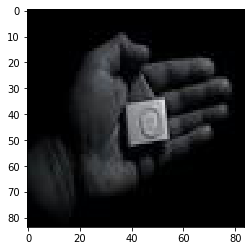

In [16]:
plt.imshow(images[0])

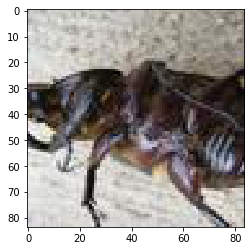

In [17]:
plt.imshow(images[600])

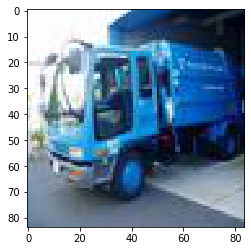

In [18]:
plt.imshow(images[1200])

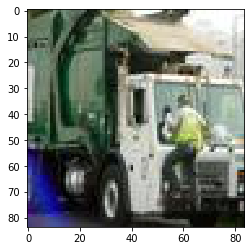

In [19]:
plt.imshow(images[1207])

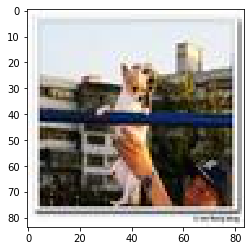

In [20]:
plt.imshow(images[1800])

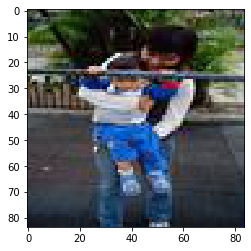

In [21]:
plt.imshow(images[1801])

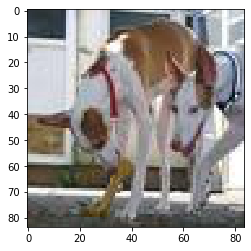

In [22]:
plt.imshow(images[2400])

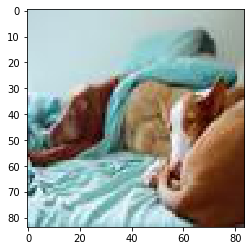

In [23]:
plt.imshow(images[2401])